#### Import Package

In [159]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import ray
import matplotlib.pyplot as plt
import quantstats as qs

from sklearn.cluster import KMeans

from class_model.model_prep import ModelPrep
from core.operation import *
from core.system import *

#### Data

In [143]:
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')

In [4]:
# Price Data
price_data = pd.read_parquet(get_parquet(live) / 'data_price.parquet.brotli')

In [5]:
# Daily Return Data
ret_daily = price_data.copy(deep=True)
ret_daily = create_return(ret_daily, windows=[1])
ret_daily = ret_daily[['RET_01']]
ret_daily = ret_daily['RET_01'].unstack(ret_daily.index.names[0])

In [8]:
# Monthly Return Data
ret_monthly = price_data.copy(deep=True)
ret_monthly = daily_to_monthly(ret_monthly)
ret_monthly = create_return(ret_monthly, windows=[1])
ret_monthly = ret_monthly[['RET_01']]
ret_monthly = ret_monthly['RET_01'].unstack(ret_monthly.index.names[0])

#### PCA

In [10]:
# Daily PCA
window_size = 21
num_components = 5
pca_daily = rolling_pca(data=ret_daily, window_size=window_size, num_components=num_components, name='daily')

In [12]:
# Monthly PCA
window_size = 6
num_components = 5
pca_monthly = rolling_pca(data=ret_monthly, window_size=window_size, num_components=num_components, name='monthly')

#### Correlation

In [25]:
# Combine PCA Daily and PCA Monthly
pca_comb = pd.merge(pca_daily, pca_monthly, left_index=True, right_index=True, how='left')
pca_comb = pca_comb.ffill().dropna()

In [28]:
# Display Correlations (Must be < 0.10 to use)
for i in range(1, 6):
    daily_column, monthly_column = f'PCA_daily_{i}', f'PCA_monthly_{i}'
    correlation = pca_comb[daily_column].corr(pca_comb[monthly_column])
    print(f"Correlation: {correlation}")

Correlation: 8.991045926071516e-05
Correlation: 0.023042217018773195
Correlation: -0.00036052485623597045
Correlation: -0.02078497253005277
Correlation: -0.0007201095323337038


In [30]:
# Drop Correlated Columns
pca_comb = pca_comb.drop(['PCA_monthly_1', 'PCA_monthly_5'], axis=1)

#### Regression

In [34]:
# Load in risk free rate
risk_free = pd.read_parquet(get_parquet(live) / 'data_rf.parquet.brotli')

In [42]:
# Create return
price_ret = price_data.copy(deep=True)
price_ret = create_return(price_ret, [1])
price_ret = price_ret[['RET_01']]
price_ret = price_ret.dropna()

In [36]:
# Add risk free rate to pca_comb (factor) dataframe
pca_comb = pca_comb.merge(risk_free, left_index=True, right_index=True, how='left')
pca_comb['RF'] = pca_comb['RF'].ffill()

In [46]:
# Get params for Rolling OLS
factor_col = pca_comb.columns[:-1].tolist()
ret = 'RET_01'
window = 126

In [48]:
# Execute Rolling OLS
roll_ols = rolling_ols_parallel(data=price_ret, ret=ret, factor_data=pca_comb, factor_cols=factor_col, window=window, name=f'ret_pca')

#### Beta

In [65]:
# Get beta columns
beta_col = roll_ols.columns[1:len(factor_col)+1]
beta = roll_ols[beta_col]
beta = beta.dropna()

In [70]:
# Get total beta
total_beta = beta.copy(deep=True)
total_beta = total_beta.sum(axis=1).to_frame('beta')

#### Cluster

In [180]:
# Param
num_cluster = 10
window_cluster = 21

In [95]:
# Unstack beta
cluster_beta = total_beta.unstack('permno')
cluster_beta.columns = cluster_beta.columns.get_level_values(1)

In [96]:
# Get clusters
cluster_beta = rolling_kmean(cluster_beta, window_cluster, num_cluster, 'beta')

2024-02-13 20:20:12,346	INFO worker.py:1642 -- Started a local Ray instance.


rolling_kmean took 45.455sec


In [102]:
# Sort index
cluster_beta = cluster_beta.sort_index(level=['permno', 'date'])
cluster_beta.columns =['cluster']

#### Analysis

In [148]:
# Create return
analysis_ret = price_data.copy(deep=True)
analysis_ret = create_return(analysis_ret, [1])
analysis_ret = analysis_ret[['RET_01']]

In [150]:
# Add market cap
market_cap = pd.read_parquet(get_parquet(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
analysis_ret = analysis_ret.merge(market_cap, left_index=True, right_index=True, how='left')

In [151]:
# Combine
analysis = pd.merge(cluster_beta, total_beta, left_index=True, right_index=True, how='left')
analysis = analysis.merge(analysis_ret, left_index=True, right_index=True, how='left')

In [152]:
# Group by cluster
analysis = analysis.reset_index().set_index(['date', 'cluster', 'permno']).sort_index(level=['date', 'cluster', 'permno'])

#### Plot

In [153]:
# Get last date
last = analysis.loc[analysis.index.get_level_values('date') == analysis.index.get_level_values('date').max()]
last = last.reset_index()

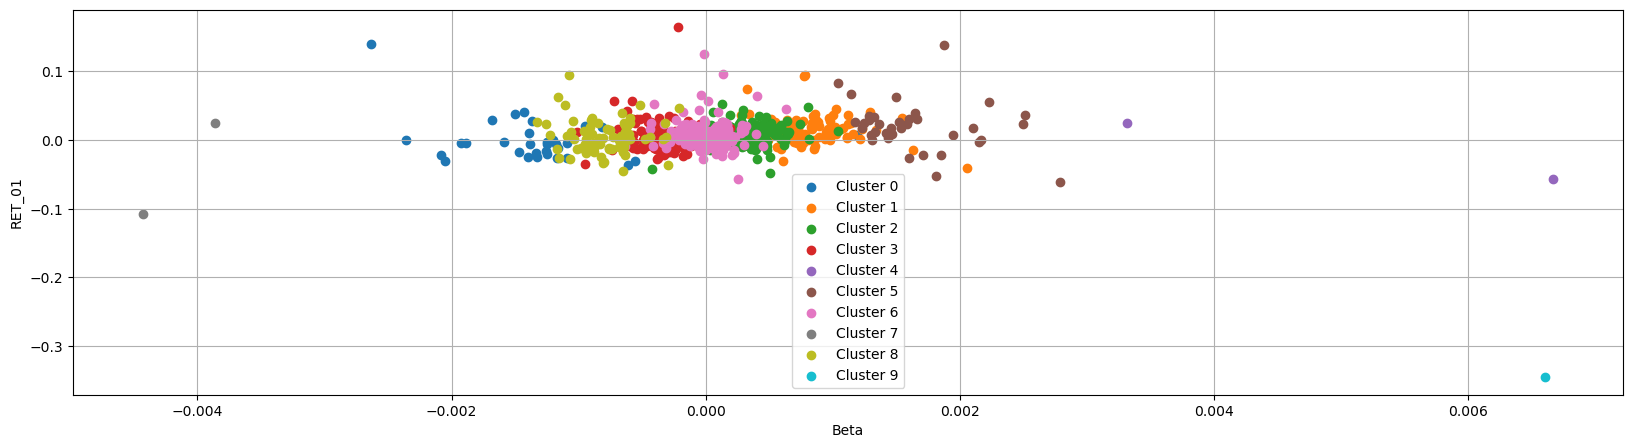

In [154]:
# Plotting
plt.figure(figsize=(20, 5))
clusters = last['cluster'].unique()

for cluster in clusters:
    # Filter data for each cluster
    temp_last = last[last['cluster'] == cluster]
    plt.scatter(temp_last['beta'], temp_last['RET_01'], label=f'Cluster {cluster}')

plt.xlabel('Beta')
plt.ylabel('RET_01')
plt.legend()
plt.grid(True)
plt.show()

#### Factor Strategy

In [186]:
# Function to select top and bottom stocks
def select_long_short_stocks(group):
    top_stocks = group.nlargest(1, 'adj_weight')
    bottom_stocks = group.nsmallest(1, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    # return pd.concat([top_stocks])
    return pd.concat([top_stocks, bottom_stocks])

# Create Factor-Based Portfolio
def create_factor_port(data, factors, threshold):
    df = data.copy(deep=True)
    # Filtering by Market Capitalization
    df = df[df['market_cap'] >= threshold]
    # Create ranks for each factor
    print("-"*60)
    print("Creating Factor Ranks...")
    for factor_name in factors:
        print(f'Factor: {factor_name}')
        df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)
    # Calculating average rank
    df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)
    # Calculating rank weights
    df['rank_weight'] = (1 / len(factors)) * df['avg_rank']
    # Calculating inverse volatility
    # df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.expanding().std())
    df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(5).std().shift(1))
    df['inv_vol_weight'] = 1 / df['vol']
    # Find adjusted weight that accounts for rank and inverse volatility
    df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']
    # Selecting Top and Bottom Stocks
    print("-"*60)
    print("Creating Long/Short portfolio...")
    top_bottom_stocks = df.groupby('date').apply(select_long_short_stocks).reset_index(level=0, drop=True)
    # Normalizing Weights
    top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())
    # Shift returns
    top_bottom_stocks['RET_01'] = top_bottom_stocks.groupby('permno')['RET_01'].shift(-1)
    top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']
    total_ret = top_bottom_stocks.groupby('date').total_ret.sum()
    return total_ret

#### Execute

In [187]:
# Params
factors = ["beta"]
threshold = 6_000_000_000

In [188]:
# Get cluster portfolios
cluster_port = []
for num, (_, cluster) in enumerate(analysis.groupby('cluster'), 1):
    print("-"*60 + f"{num}" + "-"*60)
    cluster = cluster.reset_index(level=1, drop=True)
    cluster = cluster.swaplevel()
    cluster = cluster.sort_index(level=['permno', 'date'])
    cluster_ret = create_factor_port(cluster, factors, threshold)
    cluster_port.append(cluster_ret)

------------------------------------------------------------1------------------------------------------------------------
------------------------------------------------------------
Creating Factor Ranks...
Factor: beta
------------------------------------------------------------
Creating Long/Short portfolio...
------------------------------------------------------------2------------------------------------------------------------
------------------------------------------------------------
Creating Factor Ranks...
Factor: beta
------------------------------------------------------------
Creating Long/Short portfolio...
------------------------------------------------------------3------------------------------------------------------------
------------------------------------------------------------
Creating Factor Ranks...
Factor: beta
------------------------------------------------------------
Creating Long/Short portfolio...
-------------------------------------------------------

In [189]:
# Combine cluster portfolios
port = pd.concat(cluster_port, axis=1)
total_ret = port.sum(axis=1) * (1/num_cluster)

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2006-02-06   2006-02-06
End Period                 2024-02-12   2024-02-12
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          296.75%      101.58%
CAGR﹪                     5.42%        2.72%

Sharpe                     0.49         0.28
Prob. Sharpe Ratio         98.03%       90.01%
Smart Sharpe               0.48         0.27
Sortino                    0.68         0.49
Smart Sortino              0.67         0.49
Sortino/√2                 0.48         0.35
Smart Sortino/√2           0.48         0.34
Omega                      1.07         1.07

Max Drawdown               -56.47%      -44.21%
Longest DD Days            1982         2685
Volatility (ann.)          19.73%       22.17%
R^2                        0.0          0.0
Information Ratio          -0.01        -0.01
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2016-10-07,2020-07-20,2024-02-12,2685,-44.212045,-43.176026
2,2007-10-18,2008-08-20,2009-05-06,567,-34.229763,-33.902650
3,2010-01-07,2013-07-22,2016-08-04,2402,-26.287628,-24.031914
4,2007-06-20,2007-09-13,2007-10-09,112,-21.329031,-21.139263
5,2006-08-25,2006-10-05,2006-11-20,88,-10.766906,-9.081347


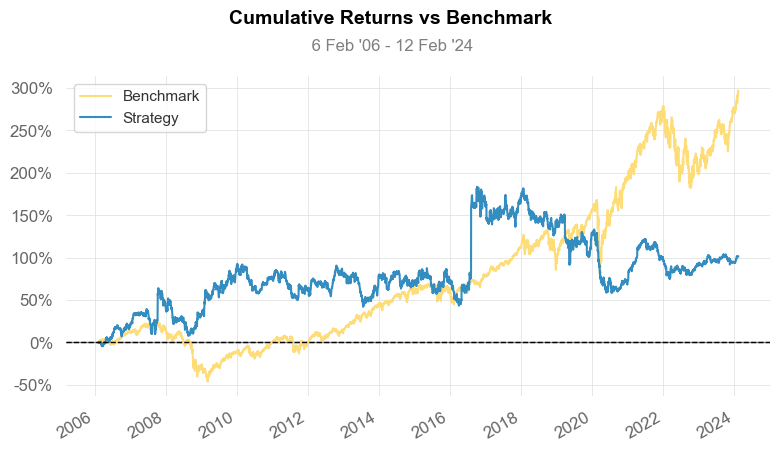

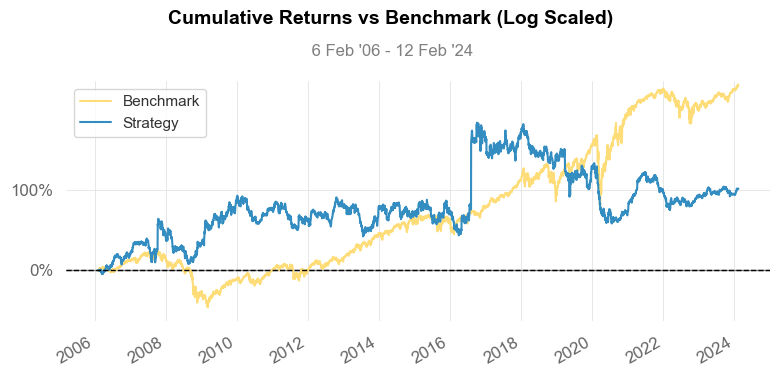

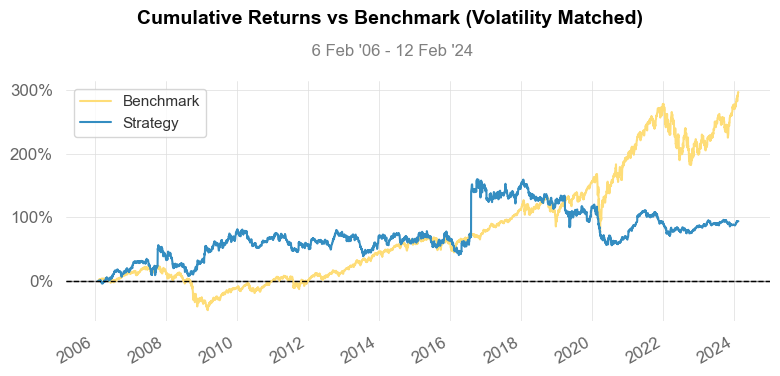

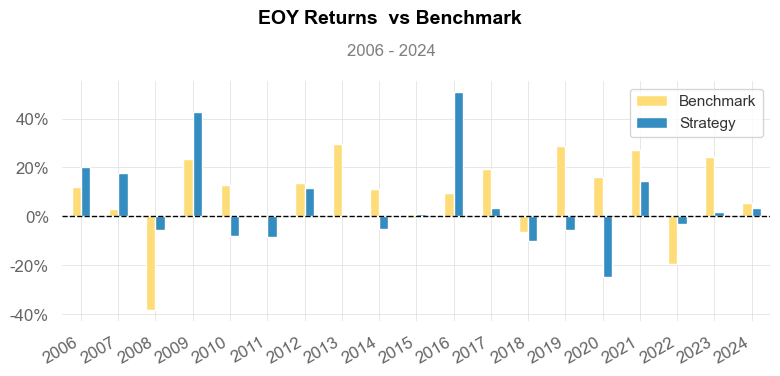

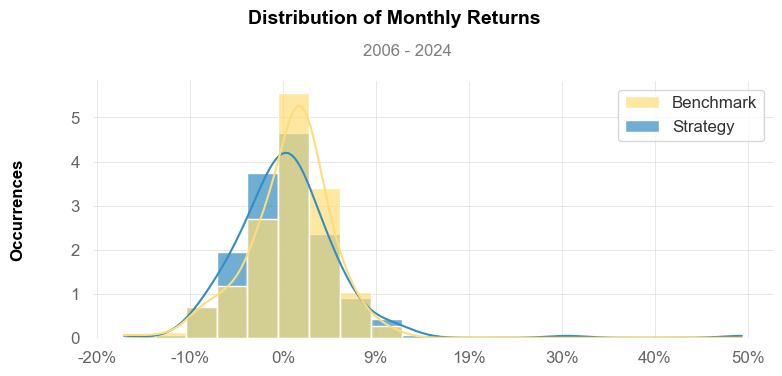

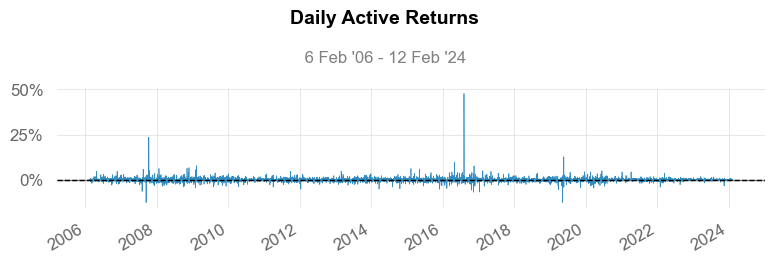

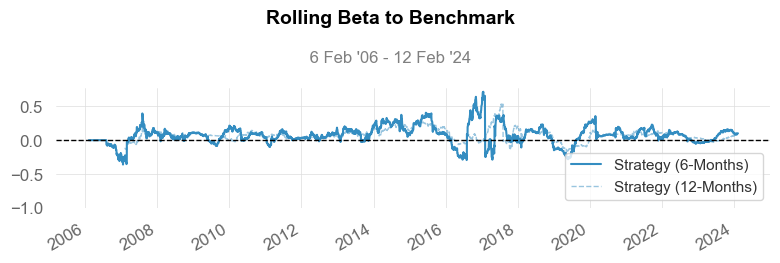

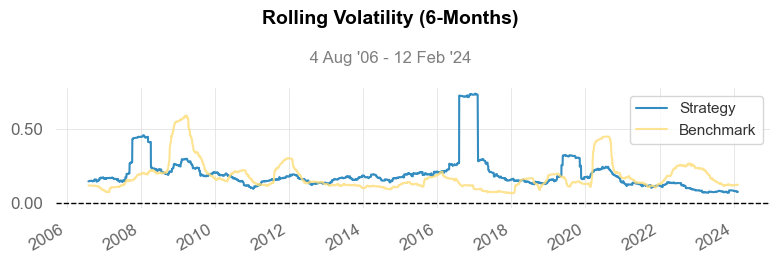

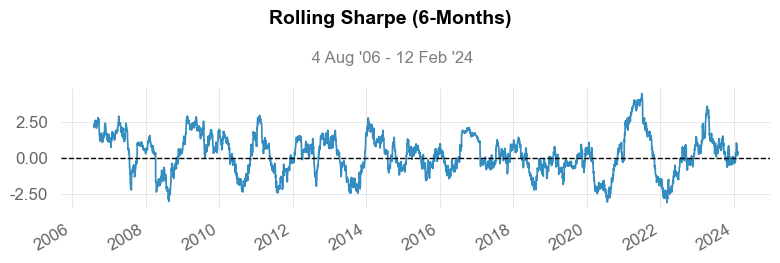

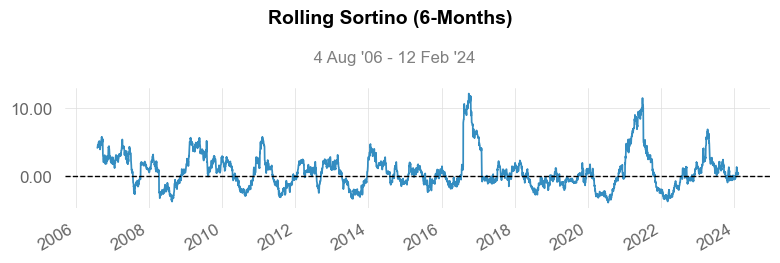

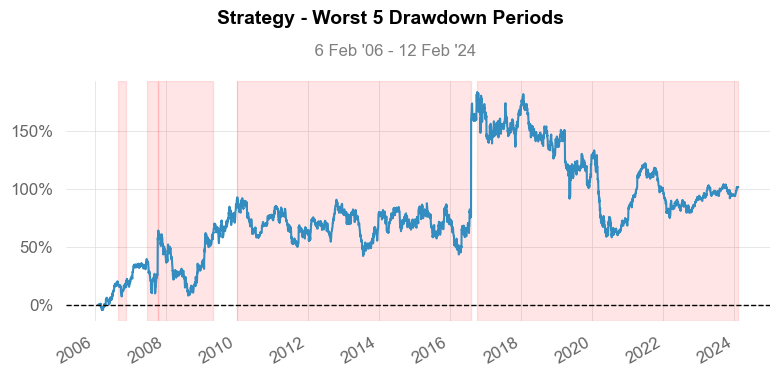

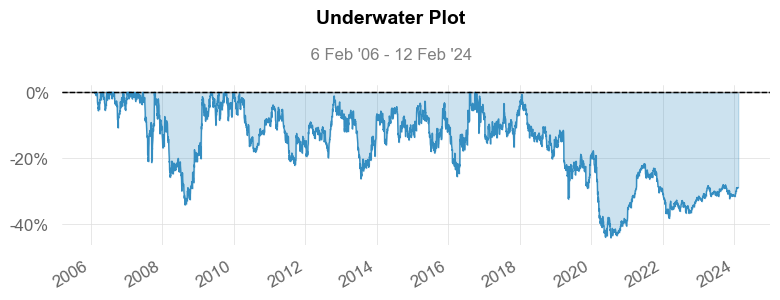

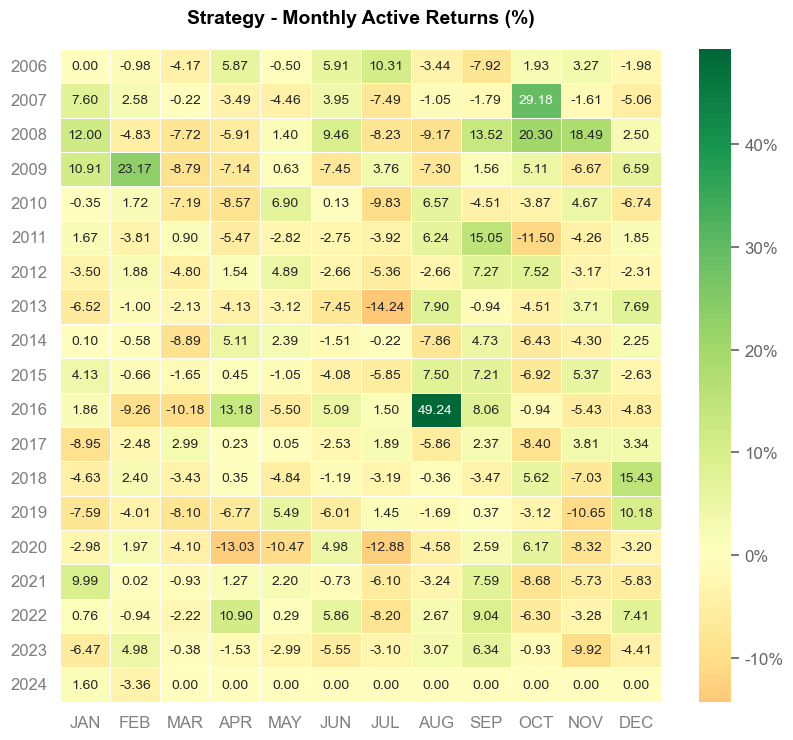

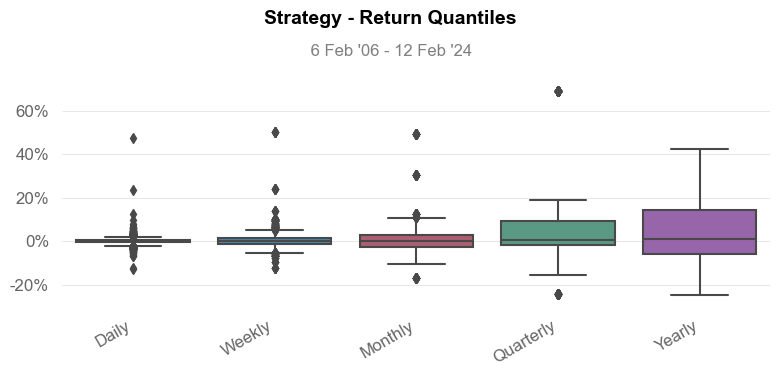

In [191]:
qs.reports.full(total_ret, 'SPY')